In [1]:
import numpy as np
import cv2
import os
import time
import glob
import matplotlib.pyplot as plt
import matplotlib.image as mpimg
from sklearn.svm import LinearSVC
from skimage.feature import hog
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import train_test_split
from scipy.ndimage.measurements import label
from moviepy.editor import VideoFileClip
from IPython.display import HTML
from datetime import datetime
import random

%matplotlib inline

In [2]:
cars_path = './vehicles/'
non_cars_path = './non-vehicles/'
output_images = './output_images/'
cars = [mpimg.imread(image_path) for image_path in glob.glob(cars_path +'*/*.png')]
notcars = [mpimg.imread(image_path) for image_path in glob.glob(non_cars_path +'*/*.png')]
print('Number of vehicle images - ' + str(len(cars)))   
print('Number of non vehicle images - ' + str(len(notcars)))
print('Size of each image - ' + str(cars[0].shape))

Number of vehicle images - 8792
Number of non vehicle images - 9015
Size of each image - (64, 64, 3)


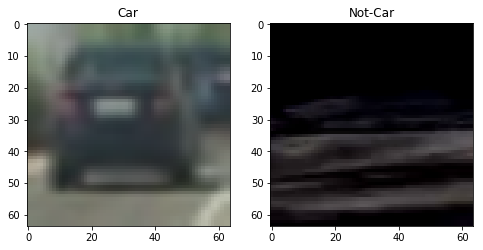

In [3]:
## Visualise images
f, (ax1, ax2) = plt.subplots(1, 2,figsize=(8,4))
ax1.set_title('Car')
ax1.imshow(cars[0])
ax2.set_title('Not-Car')
ax2.imshow(notcars[0])
plt.savefig(output_images + 'image1.png')
plt.show()

In [4]:
# Here is your draw_boxes function from the previous exercise
def draw_boxes(img, bboxes, color=(0, 0, 255), thick=6):
    # Make a copy of the image
    imcopy = np.copy(img)
    # Iterate through the bounding boxes
    for bbox in bboxes:
        # Draw a rectangle given bbox coordinates
        cv2.rectangle(imcopy, bbox[0], bbox[1], color, thick)
    # Return the image copy with boxes drawn
    return imcopy

In [5]:
 # Define a function to compute binned color features  
def bin_spatial(img, size=(32, 32)):
    # Use cv2.resize().ravel() to create the feature vector
    features = cv2.resize(img, size).ravel() 
    # Return the feature vector
    return features

In [6]:
# Define a function to compute color histogram features  
def color_hist(img, nbins=32, bins_range=(0, 256)):
    # Compute the histogram of the color channels separately
    channel1_hist = np.histogram(img[:,:,0], bins=nbins, range=bins_range)
    channel2_hist = np.histogram(img[:,:,1], bins=nbins, range=bins_range)
    channel3_hist = np.histogram(img[:,:,2], bins=nbins, range=bins_range)
    # Concatenate the histograms into a single feature vector
    hist_features = np.concatenate((channel1_hist[0], channel2_hist[0], channel3_hist[0]))
    # Return the individual histograms, bin_centers and feature vector
    return hist_features

In [7]:
# Define a function to return HOG features and visualization
def get_hog_features(img, orient, pix_per_cell, cell_per_block, 
                        vis=False, feature_vec=True):
    # Call with two outputs if vis==True
    if vis == True:
        features, hog_image = hog(img, orientations=orient, pixels_per_cell=(pix_per_cell, pix_per_cell),
                                  cells_per_block=(cell_per_block, cell_per_block), transform_sqrt=True, 
                                  visualise=vis, feature_vector=feature_vec)
        return features, hog_image
    # Otherwise call with one output
    else:
        features = hog(img, orientations=orient, pixels_per_cell=(pix_per_cell, pix_per_cell),
                       cells_per_block=(cell_per_block, cell_per_block), transform_sqrt=True, 
                       visualise=vis, feature_vector=feature_vec)
        return features

In [8]:
def convert_color(img, color_space='RGB'):
    if color_space != 'RGB':
        if color_space == 'HSV':
            feature_image = cv2.cvtColor(img, cv2.COLOR_RGB2HSV)
        elif color_space == 'LUV':
            feature_image = cv2.cvtColor(img, cv2.COLOR_RGB2LUV)
        elif color_space == 'HLS':
            feature_image = cv2.cvtColor(img, cv2.COLOR_RGB2HLS)
        elif color_space == 'YUV':
            feature_image = cv2.cvtColor(img, cv2.COLOR_RGB2YUV)
        elif color_space == 'YCrCb':
            feature_image = cv2.cvtColor(img, cv2.COLOR_RGB2YCrCb)
    else: feature_image = np.copy(img) 
    return feature_image

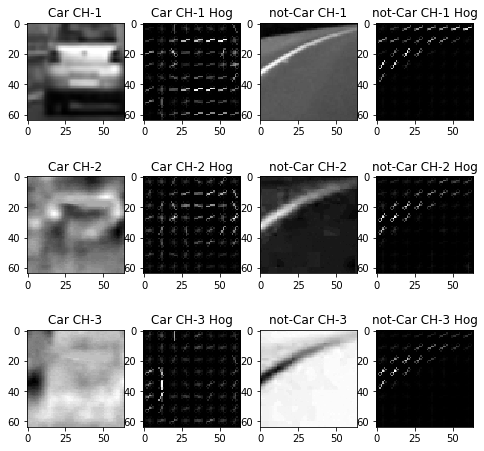

In [9]:
## Visualise HOG features
orient = 9
pix_per_cell = 8
cell_per_block = 2
# Call our function with vis=True to see an image output

converted_car_image = convert_color(cars[100], 'YCrCb')
converted_notcar_image = convert_color(notcars[100], 'YCrCb')

car_features, car_hog_image = get_hog_features(converted_car_image[:,:,0], orient, pix_per_cell, cell_per_block, vis=True, feature_vec=False)
notcar_features, notcar_hog_image = get_hog_features(converted_notcar_image[:,:,0], orient, pix_per_cell, cell_per_block, vis=True, feature_vec=False)

f, axarr = plt.subplots(3, 4,figsize=(8,8))
axarr[0,0].set_title('Car CH-1')
axarr[0,0].imshow(converted_car_image[:,:,0],'gray')
axarr[0,1].set_title('Car CH-1 Hog')
axarr[0,1].imshow(car_hog_image,'gray')
axarr[0,2].set_title('not-Car CH-1')
axarr[0,2].imshow(converted_notcar_image[:,:,0],'gray')
axarr[0,3].set_title('not-Car CH-1 Hog')
axarr[0,3].imshow(notcar_hog_image,'gray')

car_features, car_hog_image = get_hog_features(converted_car_image[:,:,1], orient, pix_per_cell, cell_per_block, vis=True, feature_vec=False)
notcar_features, notcar_hog_image = get_hog_features(converted_notcar_image[:,:,1], orient, pix_per_cell, cell_per_block, vis=True, feature_vec=False)

axarr[1,0].set_title('Car CH-2')
axarr[1,0].imshow(converted_car_image[:,:,1],'gray')
axarr[1,1].set_title('Car CH-2 Hog')
axarr[1,1].imshow(car_hog_image,'gray')
axarr[1,2].set_title('not-Car CH-2')
axarr[1,2].imshow(converted_notcar_image[:,:,1],'gray')
axarr[1,3].set_title('not-Car CH-2 Hog')
axarr[1,3].imshow(notcar_hog_image,'gray')

car_features, car_hog_image = get_hog_features(converted_car_image[:,:,2], orient, pix_per_cell, cell_per_block, vis=True, feature_vec=False)
notcar_features, notcar_hog_image = get_hog_features(converted_notcar_image[:,:,2], orient, pix_per_cell, cell_per_block, vis=True, feature_vec=False)
axarr[2,0].set_title('Car CH-3')
axarr[2,0].imshow(converted_car_image[:,:,2],'gray')
axarr[2,1].set_title('Car CH-3 Hog')
axarr[2,1].imshow(car_hog_image,'gray')
axarr[2,2].set_title('not-Car CH-3')
axarr[2,2].imshow(converted_notcar_image[:,:,2],'gray')
axarr[2,3].set_title('not-Car CH-3 Hog')
axarr[2,3].imshow(notcar_hog_image,'gray')
plt.savefig(output_images + 'image2.png')
plt.show()

In [10]:
# Define a function to extract features from a single image window
# This function is very similar to extract_features()
# just for a single image rather than list of images
def single_img_features(img, color_space='RGB', spatial_size=(32, 32),
                        hist_bins=32, orient=9, 
                        pix_per_cell=8, cell_per_block=2, hog_channel=0,
                        spatial_feat=True, hist_feat=True, hog_feat=True):    
    #1) Define an empty list to receive features
    img_features = []
    #2) Apply color conversion if other than 'RGB'
    feature_image = convert_color(img, color_space)     
    #3) Compute spatial features if flag is set
    if spatial_feat == True:
        spatial_features = bin_spatial(feature_image, size=spatial_size)
        #4) Append features to list
        img_features.append(spatial_features)
    #5) Compute histogram features if flag is set
    if hist_feat == True:
        hist_features = color_hist(feature_image, nbins=hist_bins)
        #6) Append features to list
        img_features.append(hist_features)
    #7) Compute HOG features if flag is set
    if hog_feat == True:
        if hog_channel == 'ALL':
            hog_features = []
            for channel in range(feature_image.shape[2]):
                hog_features.extend(get_hog_features(feature_image[:,:,channel], 
                                    orient, pix_per_cell, cell_per_block, 
                                    vis=False, feature_vec=True))      
        else:
            hog_features = get_hog_features(feature_image[:,:,hog_channel], orient, 
                        pix_per_cell, cell_per_block, vis=False, feature_vec=True)
        #8) Append features to list
        img_features.append(hog_features)

    #9) Return concatenated array of features
    return np.concatenate(img_features)

In [11]:
def extract_features(imgs, color_space='RGB', spatial_size=(32, 32),
                        hist_bins=32, orient=9, 
                        pix_per_cell=8, cell_per_block=2, hog_channel=0,
                        spatial_feat=True, hist_feat=True, hog_feat=True):
    # Create a list to append feature vectors to
    features = []
    # Iterate through the list of images
    for img in imgs:
        features.append(single_img_features(img, color_space=color_space, spatial_size=spatial_size,
                        hist_bins=hist_bins, orient=orient, 
                        pix_per_cell=pix_per_cell, cell_per_block=cell_per_block, hog_channel=hog_channel,
                        spatial_feat=spatial_feat, hist_feat=hist_feat, hog_feat=hog_feat))
    return features

In [12]:
### TODO: Tweak these parameters and see how the results change.
color_space = 'YCrCb' # Can be RGB, HSV, LUV, HLS, YUV, YCrCb
orient = 9  # HOG orientations
pix_per_cell = 8 # HOG pixels per cell
cell_per_block = 2 # HOG cells per block
hog_channel = "ALL" # Can be 0, 1, 2, or "ALL"
spatial_size = (16, 16) # Spatial binning dimensions
hist_bins = 16    # Number of histogram bins
spatial_feat = True # Spatial features on or off
hist_feat = True # Histogram features on or off
hog_feat = True # HOG features on or off
y_start_stop = [400, 656] # Min and max in y to search in slide_window()
scale = 1.5


car_features = extract_features(cars, color_space=color_space, 
                        spatial_size=spatial_size, hist_bins=hist_bins, 
                        orient=orient, pix_per_cell=pix_per_cell, 
                        cell_per_block=cell_per_block, 
                        hog_channel=hog_channel, spatial_feat=spatial_feat, 
                        hist_feat=hist_feat, hog_feat=hog_feat)
notcar_features = extract_features(notcars, color_space=color_space, 
                        spatial_size=spatial_size, hist_bins=hist_bins, 
                        orient=orient, pix_per_cell=pix_per_cell, 
                        cell_per_block=cell_per_block, 
                        hog_channel=hog_channel, spatial_feat=spatial_feat, 
                        hist_feat=hist_feat, hog_feat=hog_feat)


X = np.vstack((car_features, notcar_features)).astype(np.float64)                        
# Fit a per-column scaler
X_scaler = StandardScaler().fit(X)
# Apply the scaler to X
scaled_X = X_scaler.transform(X)

# Define the labels vector
y = np.hstack((np.ones(len(car_features)), np.zeros(len(notcar_features))))


# Split up data into randomized training and test sets
rand_state = np.random.randint(0, 100)
X_train, X_test, y_train, y_test = train_test_split(scaled_X, y, test_size=0.2, random_state=rand_state)


print('Using:',orient,'orientations',pix_per_cell,
    'pixels per cell and', cell_per_block,'cells per block')
print('Feature vector length:', len(X_train[0]))
# Use a linear SVC 
svc = LinearSVC()
# Check the training time for the SVC
t=time.time()
svc.fit(X_train, y_train)
t2 = time.time()
print(round(t2-t, 2), 'Seconds to train SVC...')
# Check the score of the SVC
print('Test Accuracy of SVC = ', round(svc.score(X_test, y_test), 4))
# Check the prediction time for a single sample
t=time.time()



Using: 9 orientations 8 pixels per cell and 2 cells per block
Feature vector length: 6108
21.06 Seconds to train SVC...
Test Accuracy of SVC =  0.9902


In [13]:
def add_heat(heatmap, bbox_list):
    # Iterate through list of bboxes
    for boxes in bbox_list:
        for box in boxes:
            # Add += 1 for all pixels inside each bbox
            # Assuming each "box" takes the form ((x1, y1), (x2, y2))
            heatmap[box[0][1]:box[1][1], box[0][0]:box[1][0]] += 1

    # Return updated heatmap
    return heatmap# Iterate through list of bboxes
    
def apply_threshold(heatmap, threshold):
    # Zero out pixels below the threshold
    heatmap[heatmap <= threshold] = 0
    # Return thresholded map
    return heatmap

def labeled_bboxes(labels):
    # Iterate through all detected cars
    list_bboxes = []
    for car_number in range(1, labels[1]+1):
        # Find pixels with each car_number label value
        nonzero = (labels[0] == car_number).nonzero()
        # Identify x and y values of those pixels
        nonzeroy = np.array(nonzero[0])
        nonzerox = np.array(nonzero[1])
        # Define a bounding box based on min/max x and y
        bbox = ((np.min(nonzerox), np.min(nonzeroy)), (np.max(nonzerox), np.max(nonzeroy)))
        list_bboxes.append(bbox)
        # Draw the box on the image
        #cv2.rectangle(img, bbox[0], bbox[1], (0,0,255), 6)
    # Return the image
    return list_bboxes

In [27]:
class CarDetector:

    def __init__(self):
        self.avg_frames = 30
        self.prediction_boxes = []

    # Define a single function that can extract features using hog sub-sampling and make predictions
    def find_cars(self, img, ystart, ystop, scale, svc, X_scaler, orient, pix_per_cell, cell_per_block, spatial_size, hist_bins, color_space):

        draw_img = np.copy(img)
#         draw_search = np.copy(img)
        draw_boxes =  np.copy(img)
        orignal_image = np.copy(img)
        img = img.astype(np.float32)/255

        img_tosearch = img[ystart:ystop,:,:]
        ctrans_tosearch = convert_color(img_tosearch, color_space=color_space)
        if scale != 1:
            imshape = ctrans_tosearch.shape
            ctrans_tosearch = cv2.resize(ctrans_tosearch, (np.int(imshape[1]/scale), np.int(imshape[0]/scale)))

        ch1 = ctrans_tosearch[:,:,0]
        ch2 = ctrans_tosearch[:,:,1]
        ch3 = ctrans_tosearch[:,:,2]

        # Define blocks and steps as above
        nxblocks = (ch1.shape[1] // pix_per_cell) - cell_per_block + 1
        nyblocks = (ch1.shape[0] // pix_per_cell) - cell_per_block + 1 
        nfeat_per_block = orient*cell_per_block**2

        # 64 was the orginal sampling rate, with 8 cells and 8 pix per cell
        window = 64
        nblocks_per_window = (window // pix_per_cell) - cell_per_block + 1
        cells_per_step = 2  # Instead of overlap, define how many cells to step
        nxsteps = (nxblocks - nblocks_per_window) // cells_per_step
        nysteps = (nyblocks - nblocks_per_window) // cells_per_step

        # Compute individual channel HOG features for the entire image
        hog1 = get_hog_features(ch1, orient, pix_per_cell, cell_per_block, feature_vec=False)
        hog2 = get_hog_features(ch2, orient, pix_per_cell, cell_per_block, feature_vec=False)
        hog3 = get_hog_features(ch3, orient, pix_per_cell, cell_per_block, feature_vec=False)

        box_list = []

        for xb in range(nxsteps+1):
            for yb in range(nysteps):
                ypos = yb*cells_per_step
                xpos = xb*cells_per_step
                
                # Extract HOG for this patch
                hog_feat1 = hog1[ypos:ypos+nblocks_per_window, xpos:xpos+nblocks_per_window].ravel() 
                hog_feat2 = hog2[ypos:ypos+nblocks_per_window, xpos:xpos+nblocks_per_window].ravel() 
                hog_feat3 = hog3[ypos:ypos+nblocks_per_window, xpos:xpos+nblocks_per_window].ravel() 
                hog_features = np.hstack((hog_feat1, hog_feat2, hog_feat3))

                xleft = xpos*pix_per_cell
                ytop = ypos*pix_per_cell

                # Extract the image patch
                subimg = cv2.resize(ctrans_tosearch[ytop:ytop+window, xleft:xleft+window], (64,64))
                
#                 cv2.rectangle(draw_search,(int(xleft*scale), int(ytop*scale+ystart)),(int((xleft+window)*scale),int((ytop+window)*scale+ystart)),(random.randint(0, 254),random.randint(0, 254),random.randint(0, 254)),2)

                # Get color features
                spatial_features = bin_spatial(subimg, size=spatial_size)
                hist_features = color_hist(subimg, nbins=hist_bins)

                # Scale features and make a prediction
                test_features = X_scaler.transform(np.hstack((spatial_features, hist_features, hog_features)).reshape(1, -1))    
                #test_features = X_scaler.transform(np.hstack((shape_feat, hist_feat)).reshape(1, -1))    
                test_prediction = svc.predict(test_features)

                if test_prediction == 1:
                    xbox_left = np.int(xleft*scale)
                    ytop_draw = np.int(ytop*scale)
                    win_draw = np.int(window*scale)
                    dt = datetime.now()
                    # cv2.imwrite('./bboxes/' + str(dt.microsecond) + '.png',cv2.cvtColor(draw_img[ytop_draw+ystart:ytop_draw+win_draw+ystart,xbox_left:xbox_left+win_draw], cv2.COLOR_RGB2BGR))
                    cv2.rectangle(draw_boxes,(xbox_left, ytop_draw+ystart),(xbox_left+win_draw,ytop_draw+win_draw+ystart),(0,0,255),6)
                    box_list.append([(xbox_left, ytop_draw+ystart),(xbox_left+win_draw,ytop_draw+win_draw+ystart)])

#         plt.figure(figsize=(7,5))            
#         plt.imshow(draw_search)
#         plt.savefig(output_images + 'image3.png')
#         plt.show()
        
        heat = np.zeros_like(draw_img[:,:,0]).astype(np.float)
        
        if len(self.prediction_boxes) >= self.avg_frames:
            self.prediction_boxes.pop(0)
        self.prediction_boxes.append(box_list)
        
        # Add heat to each box in box list
        heat = add_heat(heat,self.prediction_boxes)

        # Apply threshold to help remove false positives
        heat = apply_threshold(heat,15)

        # Visualize the heatmap when displaying    
        heatmap = np.clip(heat, 0, 255)

        # Find final boxes from heatmap using label function
        labels = label(heatmap)
        list_bboxes = labeled_bboxes(labels)
        for bbox in list_bboxes:
            cv2.rectangle(draw_img, (bbox[0][0],bbox[0][1]), (bbox[1][0] , bbox[1][1]), (0,0,255), 6)
        #final_image = np.vstack((np.hstack((draw_img,np.dstack((heatmap,heatmap,heatmap))*255/np.amax(heatmap))),np.hstack((orignal_image,draw_boxes)))) 
        return draw_img

In [28]:
def process_image(image):
    out_img = car_detector.find_cars(image, y_start_stop[0], y_start_stop[1], scale, svc, X_scaler, orient, pix_per_cell, cell_per_block, spatial_size, hist_bins, color_space)
    return out_img

In [22]:
car_detector = CarDetector()
white_output = 'test_video_out.mp4'
clip1 = VideoFileClip("test_video.mp4")
white_clip = clip1.fl_image(process_image) #NOTE: this function expects color images!!
%time white_clip.write_videofile(white_output, audio=False)

[MoviePy] >>>> Building video test_video_out.mp4
[MoviePy] Writing video test_video_out.mp4


 97%|█████████▋| 38/39 [00:16<00:00,  2.39it/s]


[MoviePy] Done.
[MoviePy] >>>> Video ready: test_video_out.mp4 

CPU times: user 15.3 s, sys: 876 ms, total: 16.2 s
Wall time: 17 s


In [23]:
car_detector = CarDetector()
white_output = 'project_video_out.mp4'
clip1 = VideoFileClip("project_video.mp4")
white_clip = clip1.fl_image(process_image) #NOTE: this function expects color images!!
%time white_clip.write_videofile(white_output, audio=False)

[MoviePy] >>>> Building video project_video_out.mp4
[MoviePy] Writing video project_video_out.mp4


100%|█████████▉| 1260/1261 [07:57<00:00,  3.02it/s]


[MoviePy] Done.
[MoviePy] >>>> Video ready: project_video_out.mp4 

CPU times: user 7min 32s, sys: 26.9 s, total: 7min 59s
Wall time: 7min 58s


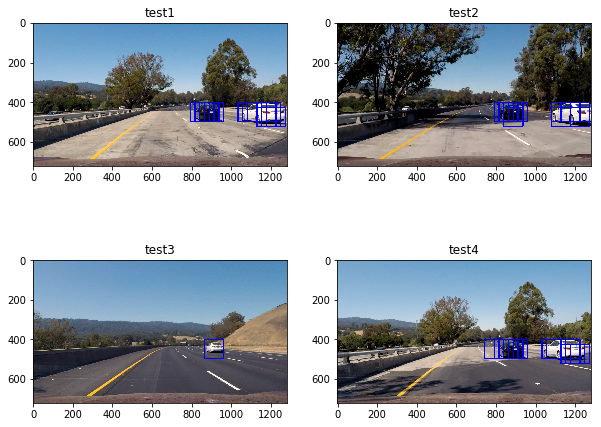

In [99]:
f, axarr = plt.subplots(2, 2,figsize=(10,8))
axarr[0,0].set_title('test1')
car_detector = CarDetector()
axarr[0,0].imshow(process_image(mpimg.imread('./test_images/test1.jpg')))
axarr[0,1].set_title('test2')
car_detector = CarDetector()
axarr[0,1].imshow(process_image(mpimg.imread('./test_images/test5.jpg')))
axarr[1,0].set_title('test3')
car_detector = CarDetector()
axarr[1,0].imshow(process_image(mpimg.imread('./test_images/test3.jpg')))
axarr[1,1].set_title('test4')
car_detector = CarDetector()
axarr[1,1].imshow(process_image(mpimg.imread('./test_images/test4.jpg')))
plt.savefig(output_images + 'image4.png')
plt.show()

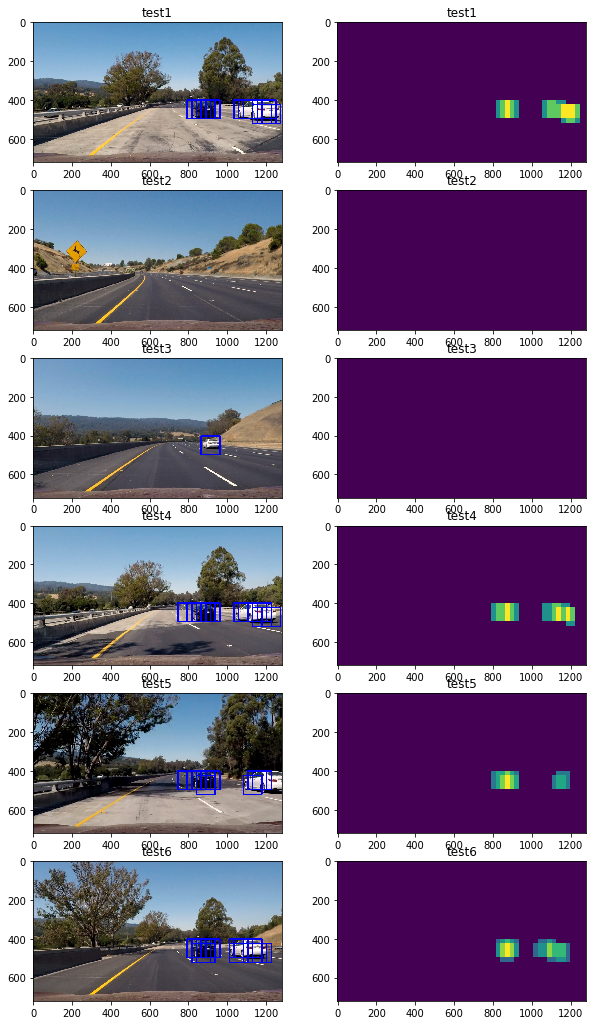

In [26]:
f, axarr = plt.subplots(6, 2,figsize=(10,18))

car_detector = CarDetector()
test_image, heatmap = process_image(mpimg.imread('./test_images/test1.jpg'))
axarr[0,0].set_title('test1')
axarr[0,0].imshow(test_image)
axarr[0,1].set_title('test1')
axarr[0,1].imshow(heatmap)

car_detector = CarDetector()
test_image, heatmap = process_image(mpimg.imread('./test_images/test2.jpg'))
axarr[1,0].set_title('test2')
axarr[1,0].imshow(test_image)
axarr[1,1].set_title('test2')
axarr[1,1].imshow(heatmap)

car_detector = CarDetector()
test_image, heatmap = process_image(mpimg.imread('./test_images/test3.jpg'))
axarr[2,0].set_title('test3')
axarr[2,0].imshow(test_image)
axarr[2,1].set_title('test3')
axarr[2,1].imshow(heatmap)

car_detector = CarDetector()
test_image, heatmap = process_image(mpimg.imread('./test_images/test4.jpg'))
axarr[3,0].set_title('test4')
axarr[3,0].imshow(test_image)
axarr[3,1].set_title('test4')
axarr[3,1].imshow(heatmap)

car_detector = CarDetector()
test_image, heatmap = process_image(mpimg.imread('./test_images/test5.jpg'))
axarr[4,0].set_title('test5')
axarr[4,0].imshow(test_image)
axarr[4,1].set_title('test5')
axarr[4,1].imshow(heatmap)

car_detector = CarDetector()
test_image, heatmap = process_image(mpimg.imread('./test_images/test6.jpg'))
axarr[5,0].set_title('test6')
axarr[5,0].imshow(test_image)
axarr[5,1].set_title('test6')
axarr[5,1].imshow(heatmap)
plt.savefig(output_images + 'image5.png')
plt.show()

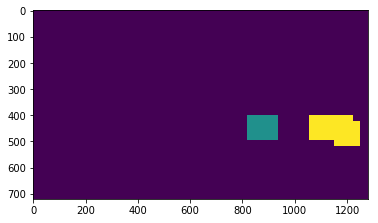

In [120]:
car_detector = CarDetector()
test_image = process_image(mpimg.imread('./test_images/test1.jpg'))
plt.imshow(test_image)
plt.savefig(output_images + 'image6.png')

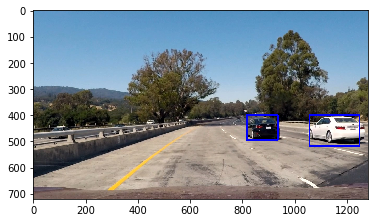

In [114]:
car_detector = CarDetector()
test_image = process_image(mpimg.imread('./test_images/test1.jpg'))
plt.imshow(test_image)
plt.savefig(output_images + 'image7.png')